In [356]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

In [357]:
pd.set_option('display.max_columns', None)

In [358]:
df = pd.read_csv(r'datasets\Engineering_graduate_salary.csv', index_col=0, parse_dates=['DOB'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 604399 to 993701
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Gender                 2998 non-null   object        
 1   DOB                    2998 non-null   datetime64[ns]
 2   10percentage           2998 non-null   float64       
 3   10board                2998 non-null   object        
 4   12graduation           2998 non-null   int64         
 5   12percentage           2998 non-null   float64       
 6   12board                2998 non-null   object        
 7   CollegeID              2998 non-null   int64         
 8   CollegeTier            2998 non-null   int64         
 9   Degree                 2998 non-null   object        
 10  Specialization         2998 non-null   object        
 11  collegeGPA             2998 non-null   float64       
 12  CollegeCityID          2998 non-null   int64         
 

In [359]:
df.dropna(inplace=True)

In [360]:
from datetime import datetime

def get_age(dob):
    today = datetime.today()
    return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))

df['Age'] = df['DOB'].apply(get_age)
df.drop(columns=['DOB'], inplace=True)



All column that a categorical

In [361]:
X = df.drop(columns=['Salary','CollegeCityID','CollegeID','12graduation', 'GraduationYear'])
y = df['Salary']
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
X[categorical_columns]

,Gender,10board,12board,Degree,Specialization,CollegeState
ID,,,,,,
604399,f,cbse,cbse,B.Tech/B.E.,instrumentation and control engineering,Delhi
988334,m,cbse,cbse,B.Tech/B.E.,computer science & engineering,Uttar Pradesh
301647,m,"maharashtra state board,pune",amravati divisional board,B.Tech/B.E.,electronics & telecommunications,Maharashtra
582313,m,cbse,cbse,B.Tech/B.E.,computer science & engineering,Delhi
339001,f,cbse,cbse,B.Tech/B.E.,biotechnology,Tamil Nadu
...,...,...,...,...,...,...
103174,f,0,0,B.Tech/B.E.,electronics and communication engineering,Tamil Nadu
352811,f,state board,state board,B.Tech/B.E.,information technology,Tamil Nadu
287070,m,bsemp,bsemp,B.Tech/B.E.,information technology,Madhya Pradesh


In [362]:
X.columns.tolist()

['Gender',
 '10percentage',
 '10board',
 '12percentage',
 '12board',
 'CollegeTier',
 'Degree',
 'Specialization',
 'collegeGPA',
 'CollegeCityTier',
 'CollegeState',
 'English',
 'Logical',
 'Quant',
 'Domain',
 'ComputerProgramming',
 'ElectronicsAndSemicon',
 'ComputerScience',
 'MechanicalEngg',
 'ElectricalEngg',
 'TelecomEngg',
 'CivilEngg',
 'conscientiousness',
 'agreeableness',
 'extraversion',
 'nueroticism',
 'openess_to_experience',
 'Age']

In [363]:
numerical_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
X[numerical_columns]

,10percentage,12percentage,CollegeTier,collegeGPA,CollegeCityTier,English,Logical,Quant,Domain,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Age
ID,,,,,,,,,,,,,,,,,,,,,,
604399,87.80,84.00,1,73.82,1,650,665,810,0.694479,485,366,-1,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889,32
988334,57.00,64.50,2,65.00,0,440,435,210,0.342315,365,-1,-1,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859,33
301647,77.33,85.17,2,61.94,0,485,475,505,0.824666,-1,400,-1,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875,33
582313,84.30,86.00,1,80.40,1,675,620,635,0.990009,655,-1,-1,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805,32
339001,82.00,75.00,2,64.30,1,575,495,365,0.278457,315,-1,-1,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103174,75.00,73.00,2,70.00,1,505,485,445,0.538387,245,333,-1,-1,-1,-1,-1,-1.1901,0.9688,-1.0697,1.35490,0.0284,34
352811,84.00,77.00,2,75.20,0,345,585,395,0.190153,315,-1,-1,-1,-1,-1,-1,-0.1082,0.0328,-0.4891,-0.29020,0.5024,31
287070,91.40,65.56,2,73.19,0,385,425,485,0.600057,435,-1,-1,-1,-1,-1,-1,-0.8810,0.1888,-0.3440,0.06230,0.6603,34


In [364]:

# numerical column that are actually categorical
for col in numerical_columns:
    if len(df[col].unique()) <10:
        print(col, df[col].unique())
        categorical_columns.append(col)
        numerical_columns.remove(col)
print("cardinality of categorical columns")
for col in X[categorical_columns]:
    print(col, X[col].nunique())
print("cardinality of numerical columns")
for col in X[numerical_columns]:
    print(col, X[col].nunique())

CollegeTier [1 2]
CollegeCityTier [1 0]
cardinality of categorical columns
Gender 2
10board 221
12board 277
Degree 4
Specialization 42
CollegeState 26
CollegeTier 2
CollegeCityTier 2
cardinality of numerical columns
10percentage 736
12percentage 717
collegeGPA 1064
English 109
Logical 104
Quant 133
Domain 221
ComputerProgramming 76
ElectronicsAndSemicon 29
ComputerScience 19
MechanicalEngg 39
ElectricalEngg 29
TelecomEngg 24
CivilEngg 15
conscientiousness 129
agreeableness 136
extraversion 142
nueroticism 204
openess_to_experience 131
Age 16


In [365]:
df['Specialization'].value_counts()

electronics and communication engineering      670
computer science & engineering                 557
information technology                         506
computer engineering                           415
computer application                           201
mechanical engineering                         155
electronics and electrical engineering         148
electronics & telecommunications                89
electrical engineering                          63
electronics & instrumentation eng               24
instrumentation and control engineering         18
information science engineering                 18
electronics and instrumentation engineering     18
civil engineering                               15
electronics engineering                         13
biotechnology                                   12
other                                           10
industrial & production engineering              8
chemical engineering                             7
applied electronics and instrum

<Axes: >

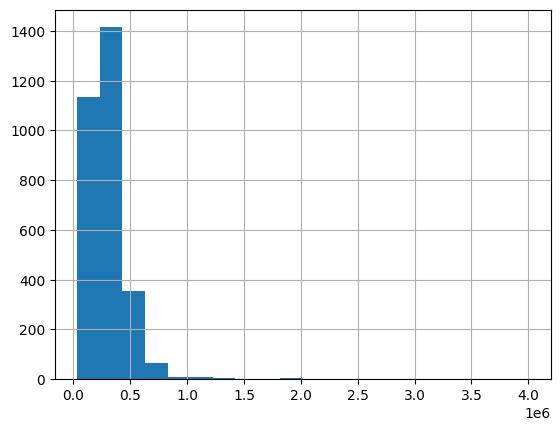

In [366]:
# fix the skewness
df['Salary'].hist(bins=20)

<Axes: >

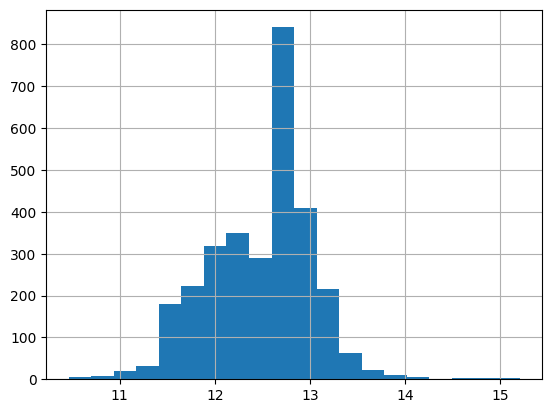

In [367]:
y = np.log1p(df['Salary'])
y.hist(bins=20)

In [368]:
import seaborn as sns
import matplotlib.pyplot as plt
# correlation with target
df[numerical_columns].corrwith(df['Salary'])

10percentage             0.181414
12percentage             0.172755
collegeGPA               0.131912
English                  0.179668
Logical                  0.193647
Quant                    0.239345
Domain                   0.132845
ComputerProgramming      0.134235
ElectronicsAndSemicon   -0.008085
ComputerScience         -0.099373
MechanicalEngg           0.032333
ElectricalEngg          -0.041403
TelecomEngg             -0.029485
CivilEngg                0.030387
conscientiousness       -0.047134
agreeableness            0.074756
extraversion            -0.004930
nueroticism             -0.069983
openess_to_experience    0.000940
Age                      0.147522
dtype: float64

In [369]:
# # boxplot
# for col in categorical_columns:
#     sns.catplot(x=col, y='Salary', data=df.sort_values('Salary', ascending=False), kind='boxen', height=6, aspect=3)
#     plt.xticks(rotation=45)
#     plt.show()

In [370]:
cols_to_drop =[
'Domain',
'ComputerProgramming',
'ElectronicsAndSemicon',
'ComputerScience',
'MechanicalEngg',
'ElectricalEngg',
'TelecomEngg',
'CivilEngg',
'conscientiousness',
'agreeableness',
'extraversion',
'nueroticism',
'openess_to_experience',
]

numerical_columns = [col for col in numerical_columns if col not in cols_to_drop]
numerical_columns

['10percentage',
 '12percentage',
 'collegeGPA',
 'English',
 'Logical',
 'Quant',
 'Age']

In [371]:
X[numerical_columns].corrwith(df['Salary'])

10percentage    0.181414
12percentage    0.172755
collegeGPA      0.131912
English         0.179668
Logical         0.193647
Quant           0.239345
Age             0.147522
dtype: float64

In [372]:
X = X[categorical_columns+numerical_columns]


<Axes: >

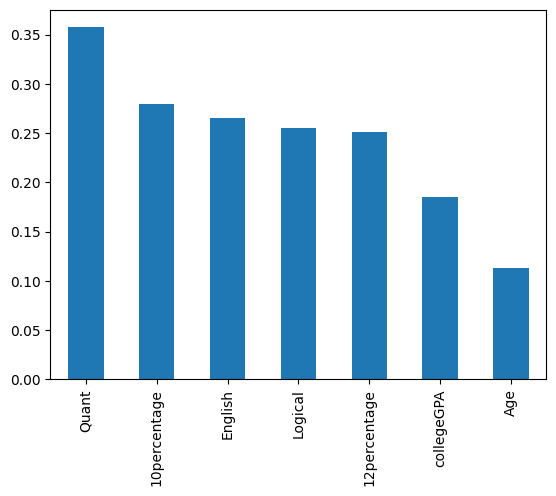

In [373]:
X[numerical_columns].corrwith(y).abs().sort_values(ascending=False).plot(kind='bar')

In [374]:
# get the name and score of best features
from sklearn.feature_selection import SelectKBest, f_regression, RFE

In [375]:
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, )
num_encoder = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('cat', cat_encoder, categorical_columns),
                                                  ('num', num_encoder, numerical_columns)])             

In [376]:
# pipeline with selectkbest
pipe = Pipeline([('preprocessor', preprocessor),
        ('selectkbest', SelectKBest(score_func=f_regression, k=10)),
        ('model',xgb.XGBRegressor())])

pipe.fit(X, y)
print(pipe.score(X, y))
y_pred = pipe.predict(X)
print('mse', mean_squared_error(y, y_pred))
print('mae', mean_absolute_error(y, y_pred))
print('r2', r2_score(y, y_pred))


0.862730743725209
mse 0.040829143367918375
mae 0.14479990067440857
r2 0.862730743725209


In [377]:
# save the model
import joblib
joblib.dump(pipe, 'model.pkl')


['model.pkl']

In [378]:
#  a function to take user input based on the columns in X and predict the salary
def predict_salary(gender, percent10th, board10th, percent12th, board12, 
                collegeTier, degree, specialization, collegeGPA, 
                CollegeCityTier, CollegeState, 
                English, Logical, Quant, Age):
    # create a dataframe with the user input
    udf = pd.DataFrame({
        'Gender': [gender],
        '10percentage': [percent10th],
        '10board': [board10th],
        '12percentage': [percent12th],
        '12board': [board12],
        'CollegeTier': [collegeTier],
        'Degree': [degree],
        'Specialization'    : [specialization],
        'collegeGPA': [collegeGPA],
        'CollegeCityTier': [CollegeCityTier],
        'CollegeState': [CollegeState],
        'English': [English],
        'Logical': [Logical],
        'Quant': [Quant],
        'Age' : [Age]
    })
    
    model = joblib.load('model.pkl')
    ans = model.predict(udf)
    return ans[0]


In [379]:
# predict the salary
model = joblib.load('model.pkl')
salary = model.predict(X.iloc[0:1])[0]
print("calculated salary", np.expm1(salary))

calculated salary 483686.94


In [380]:
np.expm1(0.1386403397376724)

0.14871088004220503

In [381]:
X.iloc[0:1]

,Gender,10board,12board,Degree,Specialization,CollegeState,CollegeTier,CollegeCityTier,10percentage,12percentage,collegeGPA,English,Logical,Quant,Age
ID,,,,,,,,,,,,,,,
604399,f,cbse,cbse,B.Tech/B.E.,instrumentation and control engineering,Delhi,1,1,87.8,84.0,73.82,650,665,810,32


In [382]:
df['predicted_salary'] = np.expm1(model.predict(X))

<Axes: xlabel='Salary', ylabel='Density'>

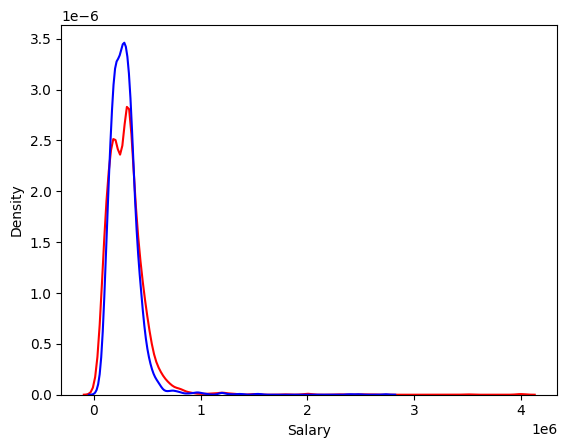

In [383]:
# kde plot
sns.kdeplot(df['Salary'],color='r')
sns.kdeplot(df['predicted_salary'], color='b')


In [384]:
# test the function
ans = predict_salary(
    gender='m',
    board10th='icse',
    board12='icse',
    degree='B.Tech/B.E.',
    specialization='computer engineering',
    CollegeState='Andhra Pradesh',
    collegeTier=2,
    CollegeCityTier=1,
    percent10th=84.3,
    percent12th=95.8,
    collegeGPA=7.8,
    English=515,
    Logical=585,
    Quant=525,
    Age=25
)
print("predicted salary", np.expm1(ans))

predicted salary 342817.03


In [385]:
# print unique values in each column in categorical columns
for col in categorical_columns:
    print(f'{col.lower()}_choice = ', df[col].unique().tolist())
    print('---------------------------------')

gender_choice =  ['f', 'm']
---------------------------------
10board_choice =  ['cbse', 'maharashtra state board,pune', 'icse', 'state board', 'delhi board', '0', 'hse', 'board of school education harayana', 'rbse', 'u p board', 'bse, odisha', 'rajasthan board of secondary education', 'up board', 'council for indian school certificate examination', 'kea', 'uttar pradesh', 'board of secondary education,andhara pradesh', 'wbbse', 'matriculation board', 'board of secondary education - andhra pradesh', 'mp', 'up', 'karnataka', 'ssc', 'kseeb', 'bse', 'gseb', 'uttar pradesh board', 'matriculation', 'karnataka secondary education board', 'maharastra board', 'tn state board', 'board of secondary education', 'sslc', 'board secondary  education', 'karnataka secondary school of examination', 'metric', 'maharashtra state board', 'maharashtra sate board', 'matric', 'hbse', 'state', 'state boardmp board ', 'karnataka board of higher education', 'hsce', 'nagpur divisional board', 'bihar board', 'jkb

In [386]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 604399 to 993701
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2998 non-null   object 
 1   10board          2998 non-null   object 
 2   12board          2998 non-null   object 
 3   Degree           2998 non-null   object 
 4   Specialization   2998 non-null   object 
 5   CollegeState     2998 non-null   object 
 6   CollegeTier      2998 non-null   int64  
 7   CollegeCityTier  2998 non-null   int64  
 8   10percentage     2998 non-null   float64
 9   12percentage     2998 non-null   float64
 10  collegeGPA       2998 non-null   float64
 11  English          2998 non-null   int64  
 12  Logical          2998 non-null   int64  
 13  Quant            2998 non-null   int64  
 14  Age              2998 non-null   int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 374.8+ KB


In [394]:
data ={'10board': {0: 'andhra pradesh state board'},
 '10percentage': {0: '90'},
 '12board': {0: ' board of intermediate'},
 '12percentage': {0: '58'},
 'Age': {0: '19'},
 'CollegeCityTier': {0: '1'},
 'CollegeState': {0: 'Punjab'},
 'CollegeTier': {0: '1'},
 'Degree': {0: 'B.Tech/B.E.'},
 'English': {0: '66'},
 'Gender': {0: 'f'},
 'Logical': {0: '66'},
 'Quant': {0: '66'},
 'Specialization': {0: 'electronics and communication engineering'},
 'collegeGPA': {0: '67'}}
udf = pd.DataFrame(data)
udf
np.expm1(model.predict(udf)[0])

218230.78